# Idefics3 Inference for Dataextraction on Invoices

[Idefics documentation on Hugging Face](https://huggingface.co/docs/transformers/v4.51.3/en/model_doc/idefics3)

[Model Card](https://huggingface.co/HuggingFaceM4/Idefics3-8B-Llama3)

[Paper](https://arxiv.org/abs/2408.12637)

## Preparation

First we'll set some variables to work with idefics locally. Loading_from_hub needs to be set to true, when running the notebook for the first time to download the model from the hub. For following runs, it can be set to false to work with locally saved model and processor.

In [1]:
dataset_id = "Aoschu/donut_model_data_for_german_invoice"
model_id = "HuggingFaceM4/Idefics3-8B-Llama3"
local_proc_repo = "idefics3-processor"
local_model_repo = "idefics3"
loading_from_hub = False
load_in_8bit = True
filename = "idefics3_output_ds2_8bit.json"

Let's load the dataset from the hub. You might want to implement saving to disk (similiar to the model) in case you are using a larger dataset. Here we are interested in the test split, so let's have a look at that.

In [2]:
from datasets import load_dataset

dataset = load_dataset(dataset_id)
test_split = dataset["test"]

test_split

Dataset({
    features: ['image', 'ground_truth'],
    num_rows: 18
})

Let's check out an example.

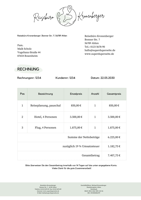

In [3]:
example = test_split[0]
image = example["image"]
width, height = image.size
display(image.resize((int(width*0.1), int(height*0.1))))

In [4]:
example["ground_truth"]

'{"gt_parse": {"Der Name der Firma": "Reisebiiro Kronenberger", "Die Adresse der Firma": "Bonner Str. 756789 Ahlen", "Telefonnummer": "01234 5678-90", "Rechnungsdatum": ": 22.05.2030", "Summe": "7.407,75", "IBAN": "DE12 3456 7890 1234 56", "Der Name der Bank": "Reisebank"}}'

Since, the image and ground truth look good, we continue to load the model. If we do this for the first time, we load it from the hub and save it to disk.

In [5]:
from transformers import AutoProcessor, AutoModelForVision2Seq

if loading_from_hub:
    processor = AutoProcessor.from_pretrained(model_id)
    model = AutoModelForVision2Seq.from_pretrained(model_id)
    processor.save_pretrained(local_proc_repo)
    model.save_pretrained(local_model_repo)

I had to use 8bit quantization, because otherwise it wouldn't quite fit into my VRAM.

In [6]:
import torch
from transformers import AutoProcessor, AutoModelForVision2Seq, BitsAndBytesConfig

DEVICE = "cuda:0"
image_size_n = 4

processor = AutoProcessor.from_pretrained(
    local_proc_repo,
    size={"longest_edge": image_size_n*364}
    )

if load_in_8bit:
    quantization_config = BitsAndBytesConfig(
        load_in_8bit=True
    )
    model = AutoModelForVision2Seq.from_pretrained(
        local_model_repo,
        quantization_config=quantization_config,
        device_map="auto"
    )
else:
    model = AutoModelForVision2Seq.from_pretrained(
    local_model_repo,
    torch_dtype=torch.float16,
    device_map="auto"
    )

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## Inference

This is where the outputs are generates, all with the same text prompt which instructs the assistant to return the extracted data in a specific JSON-Format.

In [7]:
outputs = []
for i, data in enumerate(test_split):
    # Load the image
    image = [data["image"]]
    
    # Create inputs
    message = [{
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": 'Extract all key information from the document and return it as JSON. Separate decimal places by comma for all values. Use the following format and do not add additional fields: {"Der Name der Firma": {company name}, "Die Adresse der Firma": {company address}, "Telefonnummer": {phone number}, "Rechnungsdatum": {invoice date}, "Summe": {total gross sum}, "IBAN": {bank account iban}, "Der Name der Bank": {name of the bank}}}.' },
            ]
        }]
    prompt = [processor.apply_chat_template(message, add_generation_prompt=True)]
    inputs = processor(text=prompt, images=image, padding=True, return_tensors="pt").to(model.device)
    generated_ids = model.generate(**inputs, max_new_tokens=4096)
    generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)
    outputs.append(generated_texts)
    print(f"Processed item {i + 1}/{len(test_split)}")

print("Inference loop finished.")

Processed item 1/18
Processed item 2/18
Processed item 3/18
Processed item 4/18
Processed item 5/18
Processed item 6/18
Processed item 7/18
Processed item 8/18
Processed item 9/18
Processed item 10/18
Processed item 11/18
Processed item 12/18
Processed item 13/18
Processed item 14/18
Processed item 15/18
Processed item 16/18
Processed item 17/18
Processed item 18/18
Inference loop finished.


Let's have a look at the outputs. We should see a large list holding both the prompts and the predictions.

In [8]:
outputs[:3]

[['User:<image>Extract all key information from the document and return it as JSON. Separate decimal places by comma for all values. Use the following format and do not add additional fields: {"Der Name der Firma": {company name}, "Die Adresse der Firma": {company address}, "Telefonnummer": {phone number}, "Rechnungsdatum": {invoice date}, "Summe": {total gross sum}, "IBAN": {bank account iban}, "Der Name der Bank": {name of the bank}}}.\nAssistant: {\n    "company name": "Reisebüro Kronenberger",\n    "company address": "Bonner Str. 7, 56789 Ahlen",\n    "phone number": "0123 56789-90",\n    "invoice date": "22.05.2030",\n    "total gross sum": "7,407.75",\n    "bank account iban": "DE89 1234 56789 1234 56",\n    "name of the bank": "IBAN"\n}'],
 ['User:<image>Extract all key information from the document and return it as JSON. Separate decimal places by comma for all values. Use the following format and do not add additional fields: {"Der Name der Firma": {company name}, "Die Adresse

Let's do some formatting, to make this more human readable.

In [9]:
formatted_texts = []
# Iterate through the outputs and format each output
for output in outputs:
    formatted_text = '\n'.join(output)
    formatted_texts.append(formatted_text.replace('\\n', '<br>'))
for i, formatted_text in enumerate(formatted_texts[:3]):
    print(f"Output {i+1}:")
    print(formatted_text)
    print()

Output 1:
User:<image>Extract all key information from the document and return it as JSON. Separate decimal places by comma for all values. Use the following format and do not add additional fields: {"Der Name der Firma": {company name}, "Die Adresse der Firma": {company address}, "Telefonnummer": {phone number}, "Rechnungsdatum": {invoice date}, "Summe": {total gross sum}, "IBAN": {bank account iban}, "Der Name der Bank": {name of the bank}}}.
Assistant: {
    "company name": "Reisebüro Kronenberger",
    "company address": "Bonner Str. 7, 56789 Ahlen",
    "phone number": "0123 56789-90",
    "invoice date": "22.05.2030",
    "total gross sum": "7,407.75",
    "bank account iban": "DE89 1234 56789 1234 56",
    "name of the bank": "IBAN"
}

Output 2:
User:<image>Extract all key information from the document and return it as JSON. Separate decimal places by comma for all values. Use the following format and do not add additional fields: {"Der Name der Firma": {company name}, "Die Adre

Let's save this output to disk, in case we want to come back later for the evaluation.

In [10]:
import json

try:
    with open(filename, 'w') as file: # 'w' means write text
        json.dump(outputs, file, indent=4) # indent makes it human-readable
    print(f"List successfully saved to {filename}")
except TypeError as e:
     print(f"Error saving list: {e}. JSON might not support all object types in the list.")
except Exception as e:
    print(f"Error saving list: {e}")

List successfully saved to idefics3_output_ds2_8bit.json


## Evaluation

We can load the outputs from disk again, if we decide to come back to this later.

In [2]:
import json

outputs = None
try:
    with open(filename, 'r') as file: # 'r' means read text
        outputs = json.load(file)
    print(f"List successfully loaded from {filename}")
except FileNotFoundError:
    print(f"Error: File {filename} not found.")
except json.JSONDecodeError as e:
    print(f"Error loading list: Invalid JSON format - {e}")
except Exception as e:
    print(f"Error loading list: {e}")

List successfully loaded from idefics3_output_ds2_8bit.json


In [3]:
print(outputs)

[['User:<image>Extract all key information from the document and return it as JSON. Separate decimal places by comma for all values. Use the following format and do not add additional fields: {"Der Name der Firma": {company name}, "Die Adresse der Firma": {company address}, "Telefonnummer": {phone number}, "Rechnungsdatum": {invoice date}, "Summe": {total gross sum}, "IBAN": {bank account iban}, "Der Name der Bank": {name of the bank}}}.\nAssistant: {\n    "company name": "Reisebüro Kronenberger",\n    "company address": "Bonner Str. 7, 56789 Ahlen",\n    "phone number": "0123 56789-90",\n    "invoice date": "22.05.2030",\n    "total gross sum": "7,407.75",\n    "bank account iban": "DE89 1234 56789 1234 56",\n    "name of the bank": "IBAN"\n}'], ['User:<image>Extract all key information from the document and return it as JSON. Separate decimal places by comma for all values. Use the following format and do not add additional fields: {"Der Name der Firma": {company name}, "Die Adresse 

We also need the ground truths for evaluation. We'll have a look at the first 3.

In [4]:
from datasets import load_dataset

dataset = load_dataset(dataset_id)
test_split = dataset["test"]

ground_truth_list = []
for data_item in test_split:

    gt_string = data_item["ground_truth"]
    parsed_data = json.loads(gt_string)

    inner_dict = parsed_data["gt_parse"]

    ground_truth_list.append(inner_dict)

ground_truth_list[:3]

[{'Der Name der Firma': 'Reisebiiro Kronenberger',
  'Die Adresse der Firma': 'Bonner Str. 756789 Ahlen',
  'Telefonnummer': '01234 5678-90',
  'Rechnungsdatum': ': 22.05.2030',
  'Summe': '7.407,75',
  'IBAN': 'DE12 3456 7890 1234 56',
  'Der Name der Bank': 'Reisebank'},
 {'Der Name der Firma': 'Werbeagentur Kluger,',
  'Rechnungsnummer': '01234',
  'Rechnungsdatum': '13.08.2024',
  'Falligkeitsdatum': '15.09.2024',
  'Die Adresse der Firma': 'Jede StraBe 123, 12345 Jede Stadt',
  'Summe': '2142,00 €',
  'Telefonnummer': '(0221) 1234-56',
  'IBAN': '0123 4567 8901'},
 {'Die Adresse der Firma': 'asso | 12 rset',
  'Rechnungsnummer': '12345',
  'Summe': '1.332,80',
  'Telefonnummer': '{+49} 1234/98 7654'}]

From those ground truths we'll extract the keys for the key value pairs. Notice that we do this only by looking at the first example, assuming the ground truth data is structured the same for all rows. Be aware that this only takes the key from the first example which is good enough in our case, since it matches the format given to the assistant in the instructions. There are slight variations in the dataset, meaning that there are a few more keys which are not conisdered and which will negatively affect the end result. It should be possible to change the evaluation metrics to exclude them in cases where this is more problematic.

In [5]:
keys = set()

if 'ground_truth_list' in locals() and isinstance(ground_truth_list, list):
    for item in ground_truth_list:
        if isinstance(item, dict):
            # Add top-level keys
            keys.update(item.keys())
            # Check values for nested structures
            for value in item.values():
                if isinstance(value, dict):
                    # Add keys from nested dictionary
                    keys.update(value.keys())
                elif isinstance(value, list):
                     # If value is a list, check items within it
                     for element_in_list in value:
                         if isinstance(element_in_list, dict):
                             # Add keys from dictionary inside the list
                             keys.update(element_in_list.keys())

    print("All unique keys found (including nested & in lists):", sorted(list(keys)))

else:
    print("'ground_truth_list' not found or not a list.")



All unique keys found (including nested & in lists): ['Der Name der Bank', 'Der Name der Firma', 'Die Adresse der Firma', 'Falligkeitsdatum', 'IBAN', 'Rechnungsdatum', 'Rechnungsnummer', 'Summe', 'Telefonnummer']


Now we can extract the actual fields of interest so we can evaluate them against the ground truths. Again, we'll have a look at the first 3 of them.

In [6]:
import re
import json

def get_empty_structure():
    """Returns a fresh copy of the desired JSON structure filled with empty strings."""
    return {
        k: '' for k in keys
    }

def extract_values_robustly(data_list):
    """
    Extracts values by searching for "key": "value" patterns for known keys
    in the raw model output string. Fills a predefined structure.
    """
    parsed_results = []

    for extracted_data in data_list:
        # Basic check for expected format (list containing at least one string)
        if not isinstance(extracted_data, list) or len(extracted_data) == 0 or not isinstance(extracted_data[0], str):
            print(f"Skipping item with unexpected format: {extracted_data}")
            continue
        full_string = extracted_data[0]

        # Start with a clean, empty structure for this output data
        result_structure = get_empty_structure()

        # Iterate through all the keys for summary and header
        for key in keys:
            pattern = r'"{key}":\s*"(.*?)"'.format(key=re.escape(key))

            # Search for the first occurrence of this pattern in the string
            match = re.search(pattern, full_string)

            if match:
                # If found, extract the value (captured group 1)
                value = match.group(1)
                result_structure[key] = value
                # If no match, the key's value remains the default empty string ''

        # Add the populated (or partially populated) structure to our results
        parsed_results.append(result_structure)


    return parsed_results

# --- Execution part ---
# Make sure the 'outputs' variable contains your list of model predictions
if 'outputs' in locals() and isinstance(outputs, list) and len(outputs) > 0:
    parsed_results = extract_values_robustly(outputs)
    print(f"\n--- Parsed Results ({len(parsed_results)} items processed) ---")

     # Print the results to verify
    for i, result in enumerate(parsed_results[:3]):
        print(f"\nResult {i+1}:")
        print(json.dumps(result, indent=4))

else:
    print("Variable 'outputs' not found, is not a list, or is empty. Cannot parse.")
    parsed_results = [] # Initialize empty list


--- Parsed Results (18 items processed) ---

Result 1:
{
    "Rechnungsdatum": "",
    "Telefonnummer": "",
    "Die Adresse der Firma": "",
    "Der Name der Firma": "",
    "IBAN": "",
    "Falligkeitsdatum": "",
    "Der Name der Bank": "",
    "Summe": "",
    "Rechnungsnummer": ""
}

Result 2:
{
    "Rechnungsdatum": "15.09.2024",
    "Telefonnummer": "(021) 1234-56",
    "Die Adresse der Firma": "Jede Stra\u00dfe 123, 12345 Jede Stadt",
    "Der Name der Firma": "Kluger",
    "IBAN": "0123 4567 8901",
    "Falligkeitsdatum": "",
    "Der Name der Bank": "Antschrift Jede Stadt",
    "Summe": "2142,00 \u20ac",
    "Rechnungsnummer": ""
}

Result 3:
{
    "Rechnungsdatum": "",
    "Telefonnummer": "",
    "Die Adresse der Firma": "",
    "Der Name der Firma": "",
    "IBAN": "",
    "Falligkeitsdatum": "",
    "Der Name der Bank": "",
    "Summe": "",
    "Rechnungsnummer": ""
}


In [7]:
print(len(ground_truth_list))
print(len(parsed_results))

18
18


Now we can calculate some metrics.

Notice that Precision, recall and F1-score are typically used for classification problems, not text prediction or matching key value paris. In the context of matching key value pairs, incorrect predictions are counted both as false positive and false negative.

I've also calculated the accuracy based on the normalized tree edit distance by using the [donut-python](https://pypi.org/project/donut-python/) library. The main difference here is that, while the metrics are only counting fully correct or false predicitons per field, the three edit distance also measures how "close" any given predicitons was. You might want to implement this yourself or use another library, but I simply used it because I was comparing different models, including DONUT and so this seemed to be an easy way for an an additional baseline. I've also used the donut-python library to get the f1 score which was consistent with my own implementation in this case (not in all others).

For predictions with matching keys, I've also calculated the values word error rate as i[mplemented by the torcheval library](https://pytorch.org/torcheval/main/generated/torcheval.metrics.WordErrorRate.html#torcheval.metrics.WordErrorRate).

In [10]:
from collections.abc import Mapping, Sequence # Used for type checking in flatten function
from donut import JSONParseEvaluator # The Donut JSONParseEvaluator is used for here for better comparison of the two models
import numpy as np
from torcheval.metrics import WordErrorRate

def flatten_dict(d, parent_key='', sep='.'):
    items = {}
    for k, v in d.items() if isinstance(d, Mapping) else enumerate(d):
        new_key = f"{parent_key}{sep}{k}" if parent_key else str(k)
        if isinstance(v, Mapping):
            # If the value is a dictionary, recurse
            items.update(flatten_dict(v, new_key, sep=sep))
        elif isinstance(v, Sequence) and not isinstance(v, (str, bytes)):
            # If the value is a list/tuple (but not string/bytes), recurse
             items.update(flatten_dict(v, new_key, sep=sep))
        else:
            # It's a leaf value
            items[new_key] = v
    return items

def calculate_extraction_metrics(predictions, ground_truths):

    if len(predictions) != len(ground_truths):
        print("Error: Predictions and ground truths lists must have the same length.")
        return None

    total_tp = 0  # True Positives (field correctly extracted with correct value)
    total_fp = 0  # False Positives (field extracted but shouldn't be, or wrong value)
    total_fn = 0  # False Negatives (field should have been extracted but wasn't, or wrong value)
    accs = []
    total_fields = 0
    word_error_metric = WordErrorRate()

    for i, (pred, truth) in enumerate(zip(predictions, ground_truths)):
        # Field-Level Metrics (Precision, Recall, F1)
        flat_pred = flatten_dict(pred)
        flat_truth = flatten_dict(truth)

        # Convert to sets of (key, value) tuples for comparison
        pred_items = set(flat_pred.items())
        truth_items = set(flat_truth.items())

        def filter_empty_values(data):
            return [item for item in data if item[1]]

        non_empty_pred_items = set(filter_empty_values(pred_items))

        tp = len(pred_items.intersection(truth_items))
        fp = len(non_empty_pred_items.difference(truth_items))
        fn = len(truth_items.difference(pred_items))

        total_fields += len(flat_truth)
        
        total_tp += tp
        total_fp += fp
        total_fn += fn
        
        evaluator = JSONParseEvaluator()
        acc_score = evaluator.cal_acc(pred, truth)
        accs.append(float(acc_score))

        def get_word_error_rate(input, target):
            for input_item in input:
                for target_item in target:
                    if input_item[0] == target_item[0]:
                        word_error_metric.update(input_item[1], target_item[1])

        get_word_error_rate(pred_items, truth_items)


        # Log TP, FP, FN for the a single dataset item
        log_item_details = 100 # Set number of item you want to log
        if i == log_item_details:
            print(f"Details for the dataset item no. {log_item_details+1}:\n")
            print("  True Positives:")
            for item in pred_items.intersection(truth_items):
                print(f"    {item}")

            print("\n  False Positives:")
            for item in non_empty_pred_items.difference(truth_items):
                print(f"    {item}")

            print("\n  False Negatives:")
            for item in truth_items.difference(pred_items):
                print(f"    {item}")
            print("\n")

    # Micro-average Precision, Recall, F1
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    mean_accuracy = np.mean(accs)
    f1_eval = evaluator.cal_f1(predictions, ground_truths)
    word_error_rate = word_error_metric.compute()

    return {
        "precision": precision,
        "recall": recall, 
        "f1_score": f1,
        "f1_eval": f1_eval,
        "mean_accuracy": mean_accuracy,
        "total_tp": total_tp,
        "total_fields": total_fields,
        "word_error_rate": word_error_rate,   
    }

# Calculate and Print Metrics
if parsed_results and ground_truth_list:
    metrics = calculate_extraction_metrics(parsed_results, ground_truth_list)
    print(f"Parsed {len(ground_truth_list)} items with a total of {metrics['total_fields']} fields to predict.")
    print()
    if metrics:
        print("Validation Metrics:")
        print(f"  Total True Positives:             {metrics['total_tp']}")
        print(f"  Precision:                        {metrics['precision']:.4f}")
        print(f"  Recall:                           {metrics['recall']:.4f}")
        print(f"  F1-Score (manual score):          {metrics['f1_score']:.4f}")
        print(f"  F1-Score (evaluator):             {metrics['f1_eval']:.4f}")
        print(f"  Accuracy (Tree Edit Distance):    {metrics['mean_accuracy']:.4f}")
        print(f"  Word Error Rate:                  {metrics['word_error_rate']:.4f}")

else:
    print("No valid lists provided for predictions and/or ground truths.")

Parsed 18 items with a total of 113 fields to predict.

Validation Metrics:
  Total True Positives:             18
  Precision:                        0.3214
  Recall:                           0.1593
  F1-Score (manual score):          0.2130
  F1-Score (evaluator):             0.2130
  Accuracy (Tree Edit Distance):    0.2197
  Word Error Rate:                  0.7689
